# Regression with SageMaker Linear Learner - Captsone Project

# Overview
#### Trains, deploys and tests an AWS SageMaker LinearLearner model capable of predicting the impact of that increasing Automobile Horse Power has on Fuel Economy.
#### 1. Load DataSet into memory
#### 2. Seperate DataSet into Training/Test data
#### 3. Upload Training/Test data to S3
#### 4. Train a LinearLearner regression model
#### 5. Deploy and test the trained model
#### 6. Cleanup

# Import required libraries

In [2]:
# install seaborn library
!pip install --upgrade Seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker
import sagemaker.amazon.common as smac # sagemaker common libary
import boto3
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: Seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


# 1. Load DataSet into memory

In [3]:
# Read the data using Pandas 
fuel_economy_df = pd.read_csv('data/FuelEconomy.csv')
fuel_economy_df

,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739
...,...,...
95,162.810542,27.418661
96,266.869640,15.989945
97,243.831211,19.253375
98,140.959803,29.515593


In [4]:
# Separate the data into input X (Independent variable) and Output y (Dependent Variable)
X = fuel_economy_df[['Horse Power']]
y = fuel_economy_df[['Fuel Economy (MPG)']]

print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (100, 1)
y Shape: (100, 1)


In [5]:
# Convert the datatype to float32
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

# 2. Seperate DataSet into Training/Test data

In [6]:
# Split the data into training and testing using SkLearn Library
test_size = 0.2; # 80% of the data will be used for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [7]:
# Verify that the split was successful
print("X_train", "Actual length(%):", len(X_train), "Expected length(%):", (len(X)*(1-test_size)))
print("y_train", "Actual length(%):", len(y_train), "Expected length(%):", (len(y)*(1-test_size)))

print("X_test", "Actual length(%):", len(X_test), "Expected length(%):", (len(X)*test_size))
print("y_test", "Actual length(%):", len(y_test), "Expected length(%):", (len(X)*test_size))

X_train Actual length(%): 80 Expected length(%): 80.0
y_train Actual length(%): 80 Expected length(%): 80.0
X_test Actual length(%): 20 Expected length(%): 20.0
y_test Actual length(%): 20 Expected length(%): 20.0


# 3. Upload Training/Test data to S3

In [8]:
# Create Sagemaker session
sagemaker_session = sagemaker.Session()

# Define S3 bucket and prefix
bucket_name = 'aws.ml.engineer2'
bucket_key_base = 'fuel_economy_linear_learner'

# Get notebook execution role
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::628298263648:role/AmazonSageMaker-ExecutionRole-SageMaker-S3-FullAccess


## 3.1 Upload Training data to S3

In [9]:
# Ensure the target label is a vector
y_train = y_train[:,0]

# Convert the training data numpy arrays to RecordIO format (required by Sagemaker Linear Learner)
buf = io.BytesIO() # Create an in-memory byte array
smac.write_numpy_to_dense_tensor(buf, X_train, y_train) # Write data to buffer
buf.seek(0) # Reset buffer index

0

In [10]:
# Upload the training data record-io data to S3 bucket
bucket_key_train = os.path.join(bucket_key_base, 'train', "linear-train-data")
boto3.resource('s3').Bucket(bucket_name).Object(bucket_key_train).upload_fileobj(buf)

s3_train_data = 's3://{}/{}'.format(bucket_name, bucket_key_train)
print('Uploaded training data location: {}'.format(s3_train_data))

Uploaded training data location: s3://aws.ml.engineer2/fuel_economy_linear_learner/train/linear-train-data


## 3.2 Upload Test data to S3

In [11]:
# Ensure the target label is a vector
y_test = y_test[:,0]

# Convert the training data numpy arrays to RecordIO format (required by Sagemaker Linear Learner)
buf = io.BytesIO() # Create an in-memory byte array
smac.write_numpy_to_dense_tensor(buf, X_test, y_test) # Write data to buffer
buf.seek(0) # Reset buffer index

0

In [12]:
# Upload the training data record-io data to S3 bucket
bucket_key_test = os.path.join(bucket_key_base, 'test', "linear-test-data")
boto3.resource('s3').Bucket(bucket_name).Object(bucket_key_test).upload_fileobj(buf)

s3_test_data = 's3://{}/{}'.format(bucket_name, bucket_key_test)
print('Uploaded test data location: {}'.format(s3_test_data))

Uploaded test data location: s3://aws.ml.engineer2/fuel_economy_linear_learner/test/linear-test-data


# 4. Train a LinearLearner regression model

In [14]:
# S3 location to store store the linear learner output
output_location = 's3://{}/{}/output'.format(bucket_name, bucket_key_base)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://aws.ml.engineer2/fuel_economy_linear_learner/output


In [15]:
# Obtain reference LinearLearner container image (training container of sagemaker built-in algorithm)
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [16]:
# Create estimator
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

# Set hyperparameters
linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32, # train 32 models and pick the best one
                           loss = 'absolute_loss')

# Train the linear learner regression model
linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-03-18-18-00-06-891


2023-03-18 18:00:10 Starting - Starting the training job......
2023-03-18 18:00:56 Starting - Preparing the instances for training.........
2023-03-18 18:02:45 Downloading - Downloading input data
2023-03-18 18:02:45 Training - Downloading the training image.........
2023-03-18 18:04:01 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/18/2023 18:04:17 INFO 140106430957376] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

# 5. Deploy and test the trained model

In [17]:
# Deploy linear learner regression model to a sagemaker endpoint

linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())


INFO:sagemaker:Creating model with name: linear-learner-2023-03-18-18-06-23-331
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-03-18-18-06-23-331
INFO:sagemaker:Creating endpoint with name linear-learner-2023-03-18-18-06-23-331


---------!

In [18]:
# Run the test data through the prediction endpoint
result = linear_regressor.predict(X_test)
result  # results are in Json format

{'predictions': [{'score': 17.120885848999023},
  {'score': 17.784923553466797},
  {'score': 31.313318252563477},
  {'score': 27.850990295410156},
  {'score': 21.470460891723633},
  {'score': 27.05475616455078},
  {'score': 21.788318634033203},
  {'score': 25.635705947875977},
  {'score': 18.62554168701172},
  {'score': 21.59309196472168},
  {'score': 23.473270416259766},
  {'score': 34.21075439453125},
  {'score': 19.48073387145996},
  {'score': 25.545116424560547},
  {'score': 25.402488708496094},
  {'score': 22.102310180664062},
  {'score': 15.857717514038086},
  {'score': 17.947437286376953},
  {'score': 28.882204055786133},
  {'score': 19.047576904296875}]}

In [19]:
# Create array of scores from predictions json
# Each score value corresponds to a value for X_test a the same index
y_predicted = np.array([r['score'] for r in result['predictions']])
y_predicted.shape

(20,)

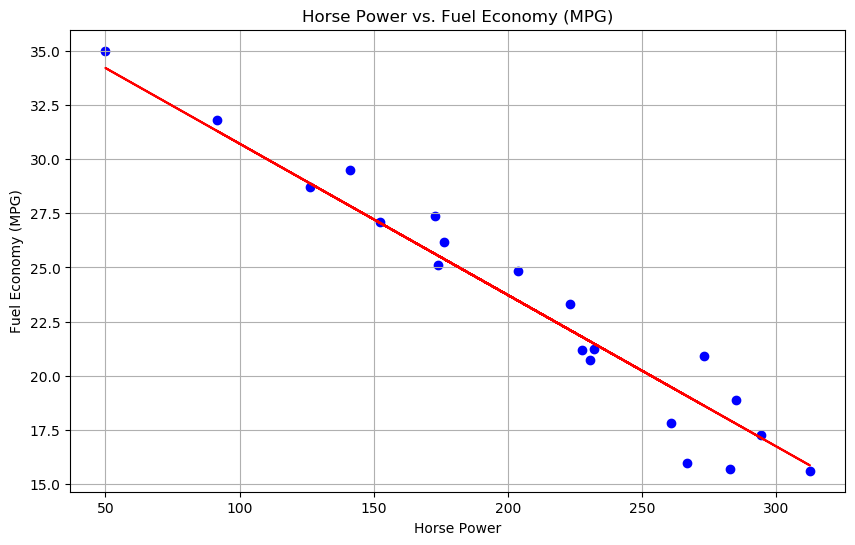

In [20]:
# Visualize the results on scatterplot
# blue dots = actual values from the test data (X = x_test values & y = y_test values)
# red line = trend line resulting from predicted values (X = x_test values & y = y_predicted values)
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, y_predicted, color = 'red')
plt.xlabel('Horse Power')
plt.ylabel('Fuel Economy (MPG)')
plt.title('Horse Power vs. Fuel Economy (MPG)')
plt.grid()
plt.show()

In [21]:
# Calculate R2 Score
# R2 is a measure of the goodness of fit of a model. An R2 of 1 indicates that the regression predictions perfectly fit the data.
r2 = r2_score(y_test, y_predicted)
r2

0.940432089801348

# 6. Cleanup

In [22]:
# Delete the SageMaker endpoint
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-03-18-18-06-23-331
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-03-18-18-06-23-331
